In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy.stats import norm
import math
import numpy as np
import math
import importlib 
from scipy.stats import norm
import scipy.integrate as nInt
from scipy.stats import t as myT
import numpy.linalg as anp
import scipy
from Functions import *

In [2]:
data = pd.read_excel('.\\adatok.xlsx', sheet_name='Sheet3')
states = pd.read_excel('.\\States.xlsx', sheet_name='Sheet1')
data['DATUM'] = data['DATUM'].apply(convert_to_quarterly)
data = pd.merge(data, states, on='DATUM', how='inner')
data

,DATUM,NO_OF_FIRMS_TOTAL,NO_OF_DEFAULTS,LGD1,LGD2,LGD3,LGD4,LGD5,P(D|G),Hectic_m,Mean_Quiet,Mean_Hectic,Quiet_Assignment,Hectic_Assignment,Q_2,H_2,Quiet_2,Hectic_2
0,1996Q1,5231,1,NaN,NaN,NaN,NaN,NaN,0.000191,0,0.972234,0.027766,1,0,0.949872,0.050128,1,0
1,1996Q2,5231,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.952914,0.047086,1,0,0.949872,0.050128,1,0
2,1996Q3,5231,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.947066,0.052934,1,0,0.949872,0.050128,1,0
3,1996Q4,5231,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.905995,0.094005,1,0,0.949872,0.050128,1,0
4,1997Q1,6157,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.958098,0.041902,1,0,0.949872,0.050128,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2023Q4,66385,70,0.306554,0.185995,0.199405,0.300555,0.497117,0.001054,0,0.525664,0.474336,1,0,0.857717,0.142283,1,0
112,2024Q1,62836,58,0.426458,0.276759,0.278882,0.369540,0.590945,0.000923,0,0.335040,0.664960,0,1,0.684815,0.315185,1,0
113,2024Q2,62836,71,0.448654,0.300499,0.315679,0.406456,0.592471,0.001130,0,0.241832,0.758168,0,1,0.487541,0.512459,0,1
114,2024Q3,62836,96,0.337895,0.172183,0.172353,0.306770,0.498617,0.001528,0,0.133307,0.866693,0,1,0.198326,0.801674,0,1


In [3]:
p_mean = data['P(D|G)'].mean()
p_mean

np.float64(0.0011946195896439494)

## Calculating a correalation estimation according to the Basel article

In [4]:
PD = p_mean

In [5]:
R = calculate_R(PD)

In [ ]:
x = np.linspace(0.0001, 0.2, 10000)
R_values = [calculate_R(i) for i in x]

plt.plot(x, R_values)
plt.xlabel('PD')
plt.ylabel('R')
plt.title('Plot of R values')
plt.grid(True)
plt.show()

# One factor Gaussian

In [6]:
#M - number of simulations
#N - number of assets in the portfolio
M = 100
alpha = np.array([0.95,0.97,0.99,0.995,0.999])
rho = R

## Monte carlo method

In [7]:
data['varSim'] = None
data['esSim'] = None
data['Sim_exp_def'] = None 
data['varSim'] = data['varSim'].astype(object)
data['esSim'] = data['esSim'].astype(object)
data['Sim_exp_def'] = data['Sim_exp_def'].astype(object)
for index, row in data.iterrows():
    N = row['NO_OF_FIRMS_TOTAL']
    p = p_mean
    c = np.ones((N,1))
    pdf, cdf, varSim, esSim, expected_defaults = oneFactorGaussianModel(N,M,p,c,rho,alpha)
    data.at[index, 'varSim'] = np.nan_to_num(varSim).tolist() if isinstance(varSim, np.ndarray) else varSim
    data.at[index, 'esSim'] = np.nan_to_num(esSim).tolist() if isinstance(esSim, np.ndarray) else esSim
    data.at[index, 'Sim_exp_def'] = expected_defaults

In [8]:
data

,DATUM,NO_OF_FIRMS_TOTAL,NO_OF_DEFAULTS,LGD1,LGD2,LGD3,LGD4,LGD5,P(D|G),Hectic_m,...,Mean_Hectic,Quiet_Assignment,Hectic_Assignment,Q_2,H_2,Quiet_2,Hectic_2,varSim,esSim,Sim_exp_def
0,1996Q1,5231,1,NaN,NaN,NaN,NaN,NaN,0.000191,0,...,0.027766,1,0,0.949872,0.050128,1,0,"[5.0, 5.0, 6.0, 6.0, 6.0]","[5.2, 5.333333333333333, 6.0, 6.0, 6.0]",2
1,1996Q2,5231,0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0.047086,1,0,0.949872,0.050128,1,0,"[5.0, 7.0, 7.0, 7.0, 7.0]","[6.2, 7.0, 7.0, 7.0, 7.0]",2
2,1996Q3,5231,0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0.052934,1,0,0.949872,0.050128,1,0,"[5.0, 6.0, 6.0, 6.0, 6.0]","[5.6, 6.0, 6.0, 6.0, 6.0]",2
3,1996Q4,5231,0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0.094005,1,0,0.949872,0.050128,1,0,"[5.0, 5.0, 7.0, 7.0, 7.0]","[5.6, 6.0, 7.0, 7.0, 7.0]",1
4,1997Q1,6157,0,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0.041902,1,0,0.949872,0.050128,1,0,"[5.0, 6.0, 7.0, 7.0, 7.0]","[6.2, 6.666666666666667, 7.0, 7.0, 7.0]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2023Q4,66385,70,0.306554,0.185995,0.199405,0.300555,0.497117,0.001054,0,...,0.474336,1,0,0.857717,0.142283,1,0,"[37.0, 38.0, 42.0, 42.0, 42.0]","[39.0, 40.333333333333336, 42.0, 42.0, 42.0]",28
112,2024Q1,62836,58,0.426458,0.276759,0.278882,0.369540,0.590945,0.000923,0,...,0.664960,0,1,0.684815,0.315185,1,0,"[35.0, 35.0, 37.0, 37.0, 37.0]","[35.6, 36.0, 37.0, 37.0, 37.0]",26
113,2024Q2,62836,71,0.448654,0.300499,0.315679,0.406456,0.592471,0.001130,0,...,0.758168,0,1,0.487541,0.512459,0,1,"[34.0, 35.0, 36.0, 36.0, 36.0]","[35.0, 35.666666666666664, 36.0, 36.0, 36.0]",25
114,2024Q3,62836,96,0.337895,0.172183,0.172353,0.306770,0.498617,0.001528,0,...,0.866693,0,1,0.198326,0.801674,0,1,"[37.0, 39.0, 42.0, 42.0, 42.0]","[39.2, 40.666666666666664, 42.0, 42.0, 42.0]",25


## Analytical one-factor Gaussian

In [9]:
p = p_mean

data['varAnalytic'] = None
data['esAnalytic'] = None
data['varAnalytic'] = data['varAnalytic'].astype(object)
data['esAnalytic'] = data['esAnalytic'].astype(object)
for index, row in data.iterrows():
    N = row['NO_OF_FIRMS_TOTAL']
    c = np.ones((N,1))
    rho = 0.02
    pdf, cdf, varAnalytic, esAnalytic = asrfModel(p, rho, c, alpha)
    data.at[index, 'varAnalytic'] = np.nan_to_num(varAnalytic).tolist() if isinstance(varAnalytic, np.ndarray) else varAnalytic
    data.at[index, 'esAnalytic'] = np.nan_to_num(esAnalytic).tolist() if isinstance(esAnalytic, np.ndarray) else esAnalytic

# Results of the Gaussian model

In [10]:
results = results = data[['DATUM', 'NO_OF_FIRMS_TOTAL', 'varSim', 'esSim', 'varAnalytic', 'esAnalytic' ]]
alpha = np.array([0.95,0.97,0.99,0.995,0.999])

In [11]:
date_to_plot = '2008Q1'

if date_to_plot in data['DATUM'].values:
    row = data.loc[data['DATUM'] == date_to_plot].iloc[0]
    varSim_values = row['varSim'] if isinstance(row['varSim'], list) else []
    esSim_values = row['esSim'] if isinstance(row['esSim'], list) else []
    varAnalytic_values = row['varAnalytic'] if isinstance(row['varAnalytic'], list) else []
    esAnalytic_values = row['esAnalytic'] if isinstance(row['esAnalytic'], list) else []

    if len(varSim_values) == len(alpha) and len(esSim_values) == len(alpha) and len(varAnalytic_values) == len(alpha) and len(esAnalytic_values) == len(alpha):
        # Create a DataFrame for the given Percentile
        risk_measures_df = pd.DataFrame({
            'Percentile': alpha,
            'varSim': varSim_values,
            'esSim': esSim_values,
            'varAnalytic': varAnalytic_values,
            'esAnalytic': esAnalytic_values,
        })

        # Print the DataFrame
        print(f"Risk Measures for the date {date_to_plot}:\n")
        print(risk_measures_df)
    else:
        print(f"Risk measures for the date {date_to_plot} are incomplete or not matching the expected length.")
else:
    print(f"No data available for the date {date_to_plot}.")



Risk Measures for the date 2008Q1:

   Percentile  varSim      esSim  varAnalytic  esAnalytic
0       0.950    47.0  50.600000   860.539918    0.009864
1       0.970    49.0  52.666667   878.469713    0.009999
2       0.990    55.0  55.000000   896.399507    0.010133
3       0.995    55.0  55.000000   900.881956    0.010167
4       0.999    55.0  55.000000   904.467915    0.010193


# State dependent model

To get the state dependent models, we need further parameters:<br>
    -$\omega$ : we already estimated in Becslesek.ipynb (estimates dataframe contains this)<br>
    -$\alpha^H$ : the correlation in hectic states (R_hectic)<br>
    -$\alpha^Q$ : the correlation in quiet states: (R_quiet)<br>


In [12]:
print(data.columns)
p_quiet_m = data.loc[data['Hectic_m'] == 0, 'P(D|G)'].mean()
p_hectic_m = data.loc[data['Hectic_m'] == 1, 'P(D|G)'].mean() 
p_quiet = data.loc[data['Hectic_m'] == 0, 'P(D|G)'].mean()
p_hectic = data.loc[data['Hectic_m'] == 1, 'P(D|G)'].mean()
print(p_quiet_m, p_hectic_m ,p_quiet, p_hectic)

Index(['DATUM', 'NO_OF_FIRMS_TOTAL', 'NO_OF_DEFAULTS', 'LGD1', 'LGD2', 'LGD3',
       'LGD4', 'LGD5', 'P(D|G)', 'Hectic_m', 'Mean_Quiet', 'Mean_Hectic',
       'Quiet_Assignment', 'Hectic_Assignment', 'Q_2', 'H_2', 'Quiet_2',
       'Hectic_2', 'varSim', 'esSim', 'Sim_exp_def', 'varAnalytic',
       'esAnalytic'],
      dtype='object')
0.0006576842084796814 0.0024149272741081935 0.0006576842084796814 0.0024149272741081935


In [13]:
R_quiet_m = calculate_R(p_quiet_m)
R_hectic_m = calculate_R(p_hectic_m)
R_quiet = calculate_R(p_quiet)
R_hectic = calculate_R(p_hectic)
print(R_quiet_m, R_hectic_m ,R_quiet, R_hectic)

0.15704171577062864 0.14946363266152687 0.15704171577062864 0.14946363266152687


# Quiet state estimation

In [14]:
p = p_quiet_m
R_quiet_m = calculate_R(p_quiet_m)
rho = R_quiet_m

data['varQuiet_Sim'] = None
data['esQuiet_Sim'] = None
data['Sim_exp_def_quiet'] = None

data['varQuiet_Sim'] = data['varQuiet_Sim'].astype(object)
data['esQuiet_Sim'] = data['esQuiet_Sim'].astype(object)
data['Sim_exp_def_quiet'] = data['Sim_exp_def_quiet'].astype(object)
for index, row in data.iterrows():
    N = row['NO_OF_FIRMS_TOTAL']
    c = np.ones((N,1))
    pdf, cdf, varQuiet_Sim, esQuiet_Sim, expected_defaults_quiet = oneFactorGaussianModel(N,M,p,c,rho,alpha)
    data.at[index, 'varQuiet_Sim'] = np.nan_to_num(varQuiet_Sim).tolist() if isinstance(varQuiet_Sim, np.ndarray) else varQuiet_Sim
    data.at[index, 'esQuiet_Sim'] = np.nan_to_num(esQuiet_Sim).tolist() if isinstance(esQuiet_Sim, np.ndarray) else esQuiet_Sim
    data.at[index, 'Sim_exp_def_quiet'] = expected_defaults_quiet

# Hectic state estimation

In [15]:
p = p_hectic_m
R_hectic_m = calculate_R(p_hectic_m)
rho = R_hectic_m


data['varHectic_Sim'] = None
data['esHectic_Sim'] = None
data['Sim_exp_def_hectic'] = None
data['varHectic_Sim'] = data['varHectic_Sim'].astype(object)
data['esHectic_Sim'] = data['esHectic_Sim'].astype(object)
data['Sim_exp_def_hectic'] = data['Sim_exp_def_hectic'].astype(object)

for index, row in data.iterrows():
    N = row['NO_OF_FIRMS_TOTAL']
    c = np.ones((N,1))
    pdf, cdf, varHectic_Sim, esHectic_Sim, expected_defaults_hectic = oneFactorGaussianModel(N,M,p,c,rho,alpha)
    data.at[index, 'varHectic_Sim'] = np.nan_to_num(varHectic_Sim).tolist() if isinstance(varHectic_Sim, np.ndarray) else varHectic_Sim
    data.at[index, 'esHectic_Sim'] = np.nan_to_num(esHectic_Sim).tolist() if isinstance(esHectic_Sim, np.ndarray) else esHectic_Sim
    data.at[index, 'Sim_exp_def_hectic'] = expected_defaults_hectic

# Results

In [16]:
date_to_plot = '2008Q1'

if date_to_plot in data['DATUM'].values:
    row = data.loc[data['DATUM'] == date_to_plot].iloc[0]
    varSim_values = row['varSim'] if isinstance(row['varSim'], list) else []
    esSim_values = row['esSim'] if isinstance(row['esSim'], list) else []
    varAnalytic_values = row['varAnalytic'] if isinstance(row['varAnalytic'], list) else []
    esAnalytic_values = row['esAnalytic'] if isinstance(row['esAnalytic'], list) else []

    varQuiet_Sim_values = row['varQuiet_Sim'] if isinstance(row['varQuiet_Sim'], list) else []
    esQuiet_Sim_values = row['esQuiet_Sim'] if isinstance(row['esQuiet_Sim'], list) else []
    varHectic_Sim_values = row['varHectic_Sim'] if isinstance(row['varHectic_Sim'], list) else []
    esHectic_Sim_values = row['esHectic_Sim'] if isinstance(row['esHectic_Sim'], list) else []

    if len(varSim_values) == len(alpha) and len(esSim_values) == len(alpha) and len(varAnalytic_values) == len(alpha) and len(esAnalytic_values) == len(alpha):
        # Create a DataFrame for the given Percentile
        risk_measures_df = pd.DataFrame({
            'Percentile': alpha,
            'varSim': varSim_values,
            'esSim': esSim_values,
            'varAnalytic': varAnalytic_values,
            'esAnalytic': esAnalytic_values,
            'varQuiet_Sim': varQuiet_Sim_values,
            'esQuiet_Sim': esQuiet_Sim_values,
            'varHectic_Sim': varHectic_Sim_values,
            'esHectic_Sim': esHectic_Sim,
        })

        # Print the DataFrame
        print(f"Risk Measures for the date {date_to_plot}:\n")
        print(risk_measures_df)
    else:
        print(f"Risk measures for the date {date_to_plot} are incomplete or not matching the expected length.")
else:
    print(f"No data available for the date {date_to_plot}.")


Risk Measures for the date 2008Q1:

   Percentile  varSim      esSim  varAnalytic  esAnalytic  varQuiet_Sim  \
0       0.950    47.0  50.600000   860.539918    0.009864          26.0   
1       0.970    49.0  52.666667   878.469713    0.009999          26.0   
2       0.990    55.0  55.000000   896.399507    0.010133          28.0   
3       0.995    55.0  55.000000   900.881956    0.010167          28.0   
4       0.999    55.0  55.000000   904.467915    0.010193          28.0   

   esQuiet_Sim  varHectic_Sim  esHectic_Sim  
0         26.6          104.0     80.200000  
1         27.0          107.0     82.333333  
2         28.0          116.0     84.000000  
3         28.0          116.0     84.000000  
4         28.0          116.0     84.000000  


In [17]:
def compute_G(N, M, Z, P_i, rho):
    Z = getGaussianY(N,M,p,rho)
    P_i = np.array(P_i)
    
    F_inv_Pi = norm.ppf(P_i)
    
    G_i = norm.cdf((F_inv_Pi - rho * Z) / np.sqrt(1 - rho**2))
    
    return G_i

In [18]:
data.to_excel('Eredmenyek1.xlsx', index=False)

# FREY LGD

In [19]:
BaselinePDEstimate = data['P(D|G)'].mean()
BaselinePDEstimate

np.float64(0.0011946195896439494)

In [20]:
LGD = 1 #Only modify this one

lgd = f'LGD{LGD}'
BaselineLGDAverage = data[lgd].mean()
BaselineLGDAverageALL = data[['LGD1', 'LGD2', 'LGD3', 'LGD4', 'LGD5']].stack().mean()
print(BaselineLGDAverage)
print(BaselineLGDAverageALL)
data['lossRate1'] = data['P(D|G)'] * data['LGD1']
data['lossRate2'] = data['P(D|G)'] * data['LGD2']
data['lossRate3'] = data['P(D|G)'] * data['LGD3']
data['lossRate4'] = data['P(D|G)'] * data['LGD4']
data['lossRate5'] = data['P(D|G)'] * data['LGD5']
averageAnnualLossRate = [data['lossRate1'].mean(), data['lossRate2'].mean(), data['lossRate3'].mean(), data['lossRate4'].mean(), data['lossRate5'].mean()]
BaselineLGDWeighted = averageAnnualLossRate[LGD-1]/BaselinePDEstimate
print(BaselineLGDWeighted)

0.2946709761227436
0.29414582805531236
0.37821601449122433


In [21]:
CorrelationEstimate = 0.12 * (1 - math.exp(-50 * BaselinePDEstimate)) / (1 - math.exp(-50)) + 0.24 * (1 - (1 - math.exp(-50 * BaselinePDEstimate)) / (1 - math.exp(-50)))
CorrelationMin = 0.12
CorrelationMax = 0.24
CorrelationEstimate

0.2330421505978185

In [22]:
def frye_jacobs_LGD(ConditionalPD, BaselinePD, BaselineLGD, Correlation):
    ConditionalLGD = norm.cdf((norm.ppf(ConditionalPD) - norm.ppf(BaselinePD) - norm.ppf(BaselinePD * BaselineLGD)) / np.sqrt(1 - Correlation)) / ConditionalPD
    
    return ConditionalLGD

In [23]:
ConditionalPD = 0.10
BaselineLGD1 = BaselineLGDAverage
BaselineLGD2 = BaselineLGDWeighted
Correlation1 = CorrelationMin
Correlation2 = CorrelationEstimate

estimatedLGD1 = frye_jacobs_LGD(ConditionalPD,BaselinePDEstimate,BaselineLGD1,Correlation1)
print(estimatedLGD1)

9.999999790871806


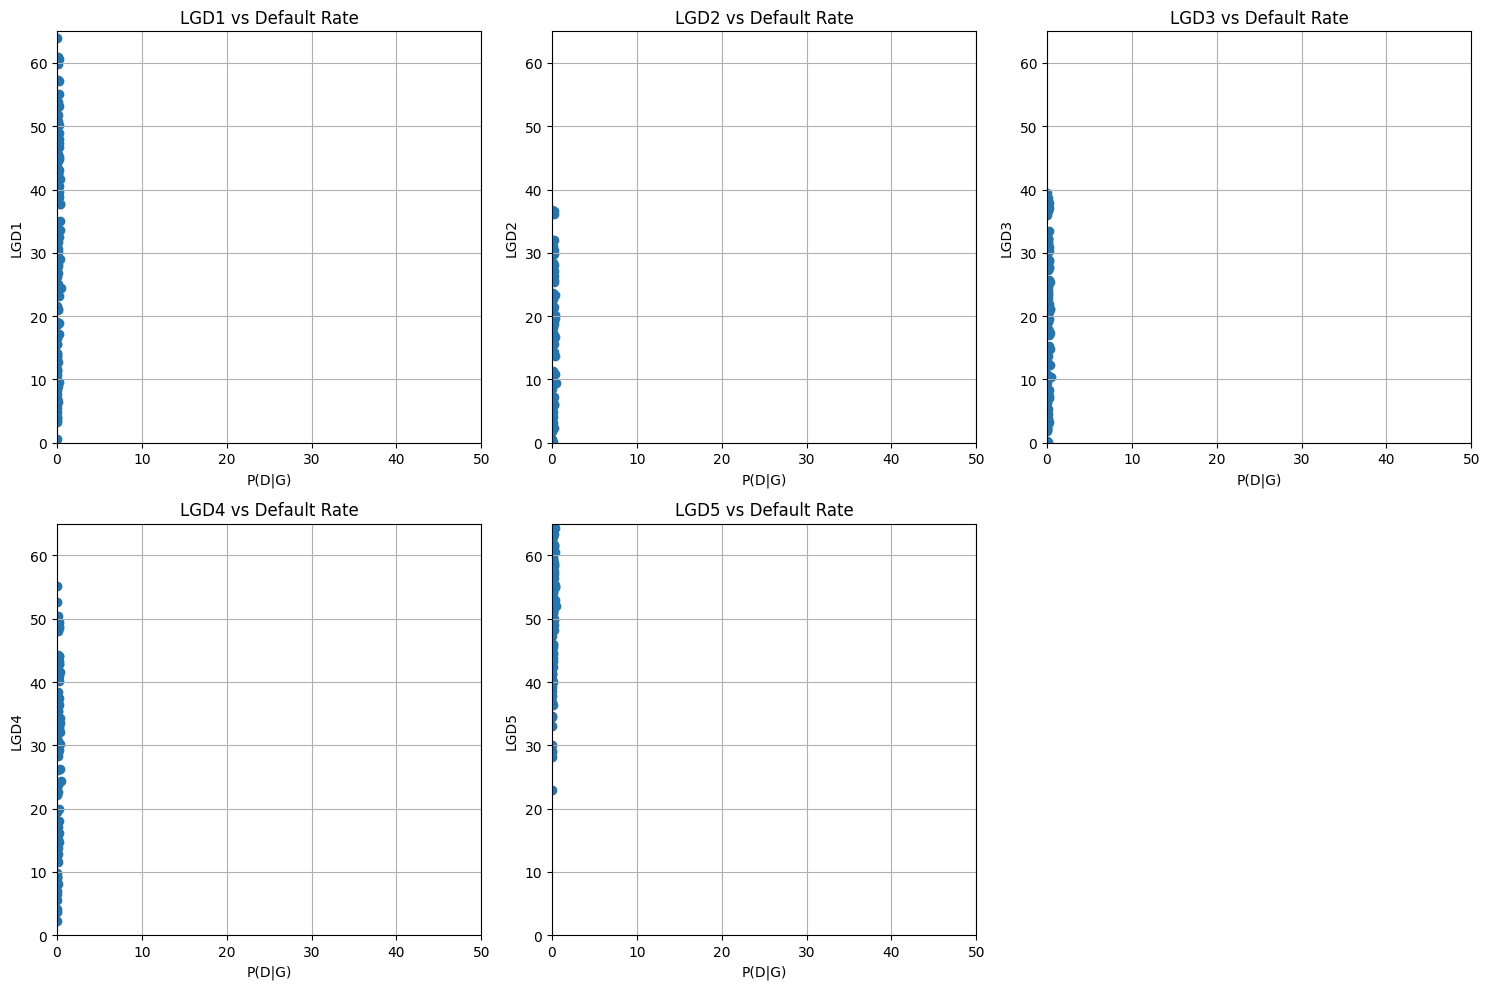

In [24]:
lgd_columns = ['LGD1', 'LGD2', 'LGD3', 'LGD4', 'LGD5']
ConditionalPD = np.linspace(0.01,0.2,1000)
ConditionalLGD1 = frye_jacobs_LGD(ConditionalPD, BaselinePDEstimate, BaselineLGD1, Correlation1)
ConditionalLGD2 = frye_jacobs_LGD(ConditionalPD, BaselinePDEstimate, BaselineLGD2, Correlation2)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()  

for i, column in enumerate(lgd_columns):
    axes[i].scatter(100*data['P(D|G)'], 100*data[column], label=column)
    axes[i].set_title(f'{column} vs Default Rate', fontsize=12)
    axes[i].set_xlabel('P(D|G)', fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)
    axes[i].grid(True)
    axes[i].set_xlim([0,50])
    axes[i].set_ylim([0,65])
    
    axes[i].plot(100*ConditionalPD, 100*ConditionalLGD1, color = 'red')
for j in range(len(lgd_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()